<a href="https://colab.research.google.com/github/bayerno/Dusk2Dawn2/blob/main/%E2%80%9Cpix2pix_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix：使用条件 GAN 进行图像到图像的转换

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/pix2pix"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/pix2pix.ipynb">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png">     在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/pix2pix.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/pix2pix.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示了如何构建和训练一个名为 pix2pix 的条件生成对抗网络 (cGAN)，该网络学习从输入图像到输出图像的映射，如 Isola 等人在 [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004){:.external} （2017 年）中所述 。pix2pix 非特定于应用，它可以应用于多种任务，包括从标签地图合成照片，从黑白图像生成彩色照片，将 Google Maps 照片转换为航拍图像，甚至将草图转换为照片。

在此示例中，您的网络将使用[布拉格捷克理工大学](http://cmp.felk.cvut.cz/~tylecr1/facade/){:.external}的[机器感知中心](http://cmp.felk.cvut.cz/){:.external}提供的 [CMP Facade Database](https://www.cvut.cz/) 来生成建筑立面。为了简化示例，您将使用由 pix2pix 作者创建的此数据集的[预处理副本](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}。

在 pix2pix cGAN 中，您可以对输入图像进行调节并生成相应的输出图像。cGAN 最初在 [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014) 中提出。

您的网络架构将包含：

- 基于 [U-Net](https://arxiv.org/abs/1505.04597){:.external} 架构的生成器。
- 由卷积 PatchGAN 分类器表示的判别器（在 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中提出）。

请注意，在单个 V100 GPU 上，每个周期可能需要大约 15 秒。

以下是 pix2pix cGAN 在 Facade Database（8 万步）上训练 200 个周期后生成的一些输出示例。

![sample output_1](https://tensorflow.google.cn/images/gan/pix2pix_1.png) ![sample output_2](https://tensorflow.google.cn/images/gan/pix2pix_2.png)

## 导入 TensorFlow 和其他库

In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

## 加载数据集

下载 CMP Facade Database 数据 (30MB)。可在[这里](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}以相同格式获得其他数据集。在 Colab 中，您可以从下拉菜单中选择其他数据集。请注意，其他一些数据集要大得多（`edges2handbags` 为 8GB）。----我修改了这部分想要导入自己的数据库

In [ ]:

# 设置数据集路径
dataset_path = '/content/drive/My Drive/My_dataset/train/combined'

# 现在，您可以使用 dataset_path 来访问您的数据集

In [ ]:
import pathlib

In [ ]:
# 使用 pathlib 创建路径对象
PATH = pathlib.Path(dataset_path)

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 挂载 Google Drive
drive.mount('/content/drive')

# 检查是否挂载成功
if os.path.exists('/content/drive/My Drive'):
    print("Google Drive 已成功挂载.")
else:
    print("Google Drive 挂载失败，请检查您的路径.")

# 数据集路径
dataset_path = '/content/drive/My Drive/My_dataset/train/combined'

# 显示数据集中的一些图像预览
sample_images = os.listdir(dataset_path)[:5]  # 选择前5个图像进行预览
plt.figure(figsize=(12, 6))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(dataset_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()

In [ ]:
import tensorflow as tf

每个原始图像的大小为 `256 x 512`，包含两个 `256 x 256` 图像：

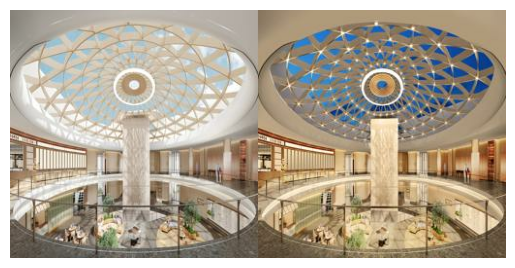

In [ ]:

import matplotlib.pyplot as plt

# 更改为正确的图像文件路径
sample_image_path = '/content/drive/My Drive/My_dataset/train/combined/train01.jpg'

# 读取PNG格式的图像文件
sample_image = tf.io.read_file(sample_image_path)
sample_image = tf.image.decode_png(sample_image, channels=3)  # channels=3表示RGB图像

# 显示图像
plt.imshow(sample_image)
plt.axis('off')

# 将图像显示到输出单元格中
plt.show()

In [ ]:
!pip install pillow

您需要将真实的建筑立面图像与建筑标签图像分开，所有这些图像的大小都是 `256 x 256`。

定义加载图像文件并输出两个图像张量的函数：

In [ ]:
import tensorflow as tf

def load(image_file):
    # 读取和解码图像文件为 uint8 张量
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # 分割每个图像张量为两个张量:
    # - 一个包含真实的建筑立面图像
    # - 一个包含建筑标签图像
    w = tf.shape(image)[1]
    w = w // 2
    facade_image = image[:, w:, :]
    label_image = image[:, :w, :]

    # 将两个图像转换为 float32 张量
    facade_image = tf.cast(facade_image, tf.float32)
    label_image = tf.cast(label_image, tf.float32)

    return facade_image, label_image
    input_image, real_image = load('/content/drive/My Drive/My_dataset/train/combined/train01.jpg')

绘制输入图像（建筑标签图像）和真实（建筑立面照片）图像的样本：

In [ ]:
%whos

Variable                    Type                  Data/Info
-----------------------------------------------------------
BATCH_SIZE                  int                   1
BUFFER_SIZE                 int                   15
Discriminator               function              <function Discriminator at 0x7e5babfef760>
Generator                   function              <function Generator at 0x7e5c0c116710>
IMG_HEIGHT                  int                   256
IMG_WIDTH                   int                   256
Image                       module                <module 'PIL.Image' from <...>t-packages/PIL/Image.py'>
LAMBDA                      int                   100
OUTPUT_CHANNELS             int                   3
PATH                        PosixPath             /content/drive/My Drive/My_dataset/train/combined
checkpoint                  Checkpoint            <tensorflow.python.checkp<...>object at 0x7e5bbc1f7490>
checkpoint_dir              str                   ./training_checkp

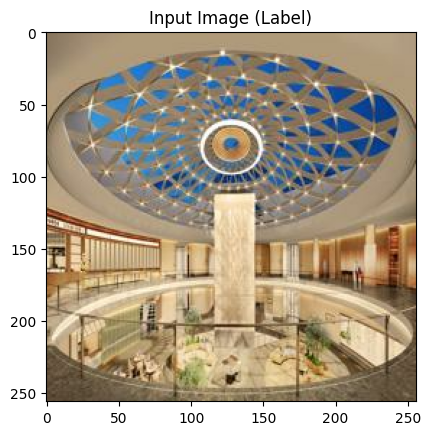

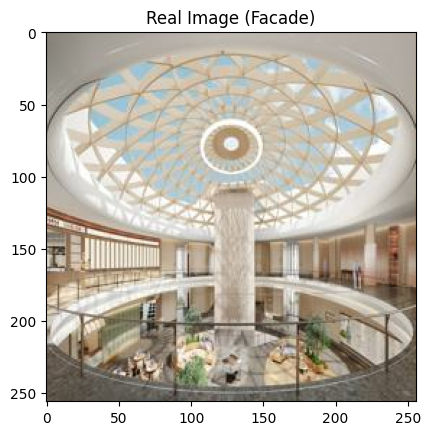

In [ ]:
import matplotlib.pyplot as plt

# 加载图像样本
inp, re = load('/content/drive/My Drive/My_dataset/train/combined/train01.jpg')

# 将图像归一化到 [0, 1] 范围
inp = inp / 255.0
re = re / 255.0

# 绘制输入图像
plt.figure()
plt.imshow(inp)
plt.title("Input Image (Label)")

# 绘制真实图像
plt.figure()
plt.imshow(re)
plt.title("Real Image (Facade)")

plt.show()

如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述，您需要应用随机抖动和镜像来预处理训练集。

定义几个具有以下功能的函数：

1. 将每个 `256 x 256` 图像调整为更大的高度和宽度，`286 x 286`。
2. 将其随机裁剪回 `256 x 256`。
3. 随机水平翻转图像，即从左到右（随机镜像）。
4. 将图像归一化到 `[-1, 1]` 范围。

In [ ]:
import tensorflow as tf
import numpy as np

BUFFER_SIZE = 15  # 根据您的数据量调整
BATCH_SIZE = 1  # 根据您的需要调整
IMG_WIDTH = 256
IMG_HEIGHT = 256
def load_and_preprocess_image(image_path):
    # 读取图像文件
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # 将图像调整为更大的 286x286
    image = tf.image.resize(image, [286, 286])

    # 随机裁剪为 256x256
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    # 随机水平翻转图像
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    # 将图像归一化到 [-1, 1] 范围
    image = (image / 127.5) - 1.0

    return image

# 创建一个数据集，将图像文件路径传递给load_and_preprocess_image函数
dataset = tf.data.Dataset.list_files('/content/drive/My Drive/My_dataset/train/combined/*.jpg')
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

您可以检查部分预处理输出：

In [ ]:
import tensorflow as tf

def random_jitter(input_image, real_image):
    # 随机裁剪图像
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    # 随机水平翻转图像
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

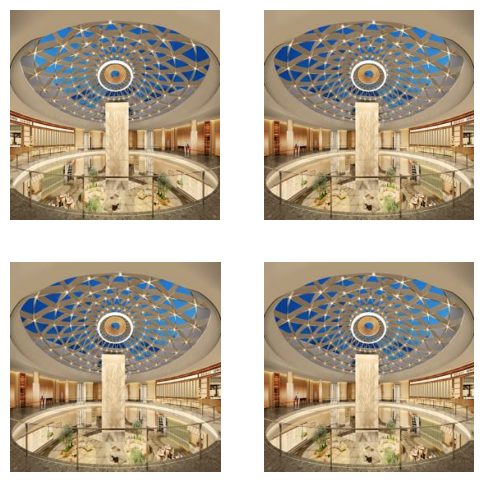

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp)
    plt.axis('off')
plt.show()

检查加载和预处理能够正常工作后，我们来定义两个辅助函数来加载和预处理训练集和测试集：

In [ ]:
def load_image_train(image_file):
    # 加载图像和进行随机预处理
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    # 加载图像和进行测试预处理
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## 使用 `tf.data` 构建输入流水线

In [ ]:
def normalize(input_image, real_image):
    # 将图像像素值缩放到[-1, 1]范围
    input_image = (input_image / 127.5) - 1.0
    real_image = (real_image / 127.5) - 1.0
    return input_image, real_image

In [ ]:
def load_image_train(image_file):
    # 加载图像和进行随机预处理
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)  # 调用normalize函数

    return input_image, real_image

In [ ]:
# 训练集图像文件路径
train_image_path = '/content/drive/My Drive/My_dataset/train/combined/*.jpg'

# 创建训练集数据集
train_dataset = tf.data.Dataset.list_files(train_image_path)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
from PIL import Image

def resize(input_image, real_image, height, width):
    # 调整输入图像和真实图像的大小
    input_image = tf.image.resize(input_image, [height, width])
    real_image = tf.image.resize(real_image, [height, width])
    return input_image, real_image

In [ ]:
# 测试集图像文件路径，首先尝试加载'test'文件夹下的图像，如果不存在则加载'val'文件夹下的图像
test_image_path = '/content/drive/My Drive/My_dataset/train/test_resized/*.jpg'
val_image_path = '/content/drive/My Drive/My_dataset/train/val/*.jpg'

# 创建测试集数据集
test_dataset = tf.data.Dataset.list_files(test_image_path)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
test_image_path = '/content/drive/My Drive/My_dataset/train/test_resized/*.jpg'
for image_file in tf.data.Dataset.list_files(test_image_path):
    input_image, real_image = load_image_test(image_file)
    print(input_image.shape, real_image.shape)

(256, 256, 3) (256, 256, 3)


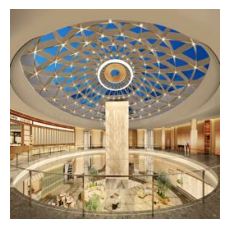

In [ ]:
import matplotlib.pyplot as plt

# 可视化加载和预处理后的图像
plt.figure(figsize=(6, 6))
for i, (input_image, real_image) in enumerate(train_dataset.take(4)):
    input_image = input_image[0]  # 从 (1, 256, 256, 3) 变为 (256, 256, 3)
    plt.subplot(2, 2, i + 1)
    plt.imshow((input_image.numpy() + 1) / 2)  # 将归一化到 [-1, 1] 范围的图像还原
    plt.axis('off')
plt.show()

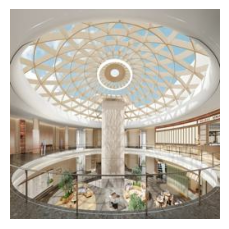

In [ ]:
import matplotlib.pyplot as plt

# 可视化加载和预处理后的真实图像
plt.figure(figsize=(6, 6))
for i, (input_image, real_image) in enumerate(train_dataset.take(4)):
    real_image = real_image[0]  # 从 (1, 256, 256, 3) 变为 (256, 256, 3)
    plt.subplot(2, 2, i + 1)
    plt.imshow((real_image.numpy() + 1) / 2)  # 将归一化到 [-1, 1] 范围的图像还原
    plt.axis('off')
plt.show()

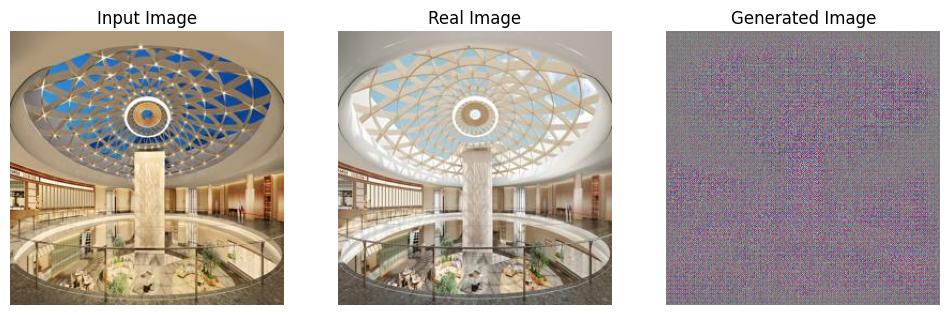

In [ ]:
import matplotlib.pyplot as plt

# 选择一张图像
sample_input, sample_real = next(iter(train_dataset))

# 使用模型生成图像
sample_generated = generator(sample_input, training=True)

# 可视化输入图像、真实图像和生成的图像
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow((sample_input[0].numpy() + 1) / 2)  # 输入图像
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow((sample_real[0].numpy() + 1) / 2)  # 真实图像
plt.title("Real Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow((sample_generated[0].numpy() + 1) / 2)  # 生成的图像
plt.title("Generated Image")
plt.axis('off')

plt.show()

## 构建生成器

您的 pix2pix cGAN 是*经过修改的* [U-Net](https://arxiv.org/abs/1505.04597){:.external}。U-Net 由编码器（下采样器）和解码器（上采样器）。（有关详细信息，请参阅[图像分割](../images/segmentation.ipynb)教程和 [U-Net 项目网站](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}。）

- 编码器中的每个块为：Convolution -&gt; Batch normalization -&gt; Leaky ReLU
- 解码器中的每个块为：Transposed convolution -&gt; Batch normalization -&gt; Dropout（应用于前三个块）-&gt; ReLU
- 编码器和解码器之间存在跳跃连接（如在 U-Net 中）。

定义下采样器（编码器）：

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


定义上采样器（解码器）：

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


使用下采样器和上采样器定义生成器：

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

可视化生成器模型架构：

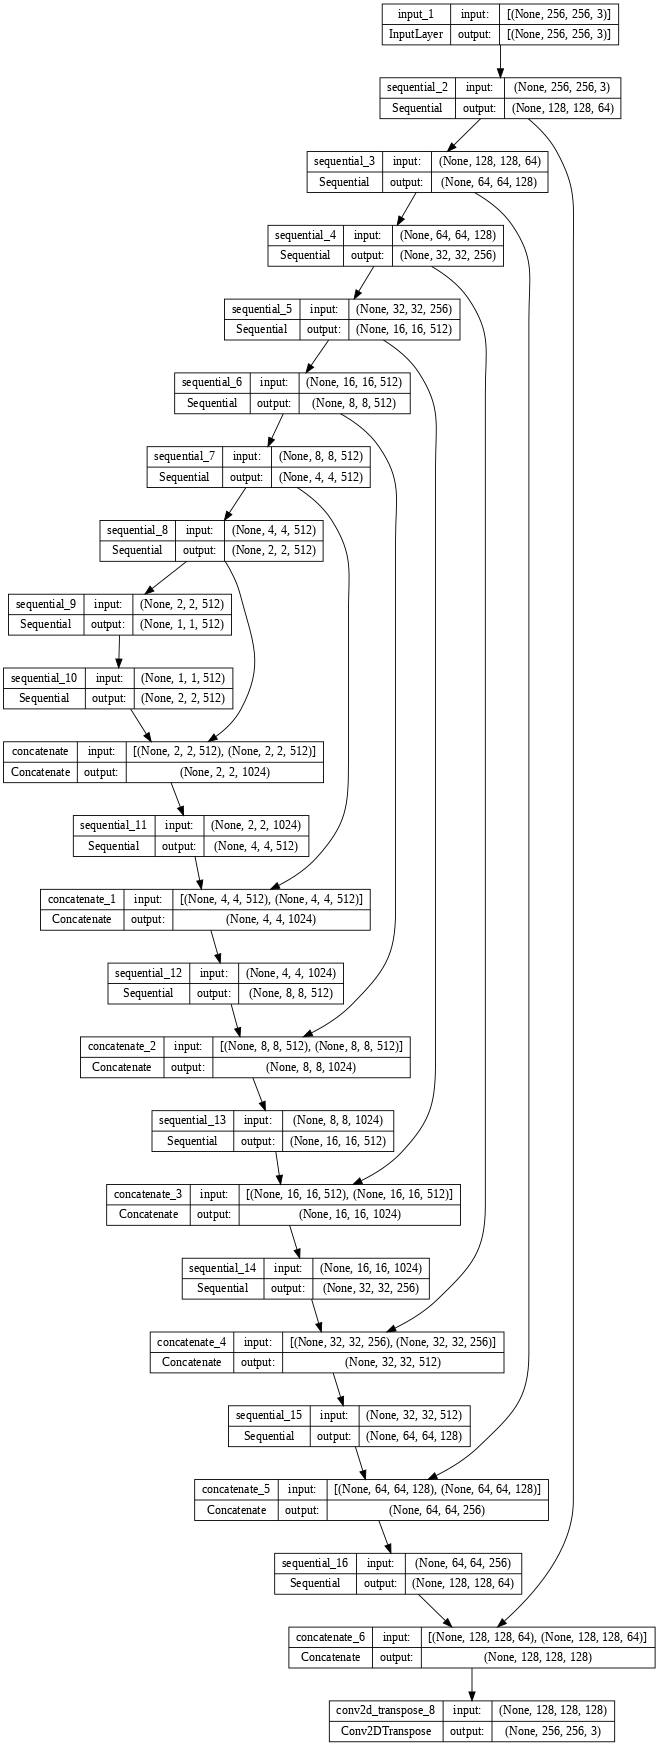

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

测试生成器：

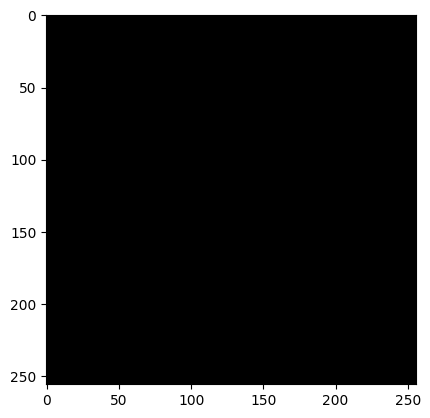

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 定义生成器损失

GAN 学习适应数据的损失，而 cGAN 学习结构化损失，该损失会惩罚与网络输出和目标图像不同的可能结构，如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述。

- 生成器损失是生成图像和**一数组**的 sigmoid 交叉熵损失。
- <a>论文</a>还提到了 L1 损失，它是生成图像与目标图像之间的 MAE（平均绝对误差）。
- 这样可使生成的图像在结构上与目标图像相似。
- 计算总生成器损失的公式为：`gan_loss + LAMBDA * l1_loss`，其中 `LAMBDA = 100`。该值由论文作者决定。

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

生成器的训练过程如下：

![生成器更新图像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## 构建判别器

pix2pix cGAN 中的判别器是一个卷积 PatchGAN 分类器，它会尝试对每个图像*分块*的真实与否进行分类，如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述。

- 判别器中的每个块为：Convolution -&gt; Batch normalization -&gt; Leaky ReLU。
- 最后一层之后的输出形状为 `(batch_size, 30, 30, 1)`。
- 输出的每个 `30 x 30` 图像分块会对输入图像的 `70 x 70` 部分进行分类。
- 判别器接收 2 个输入：
    - 输入图像和目标图像，应分类为真实图像。
    - 输入图像和生成图像（生成器的输出），应分类为伪图像。
    - 使用`tf.concat([inp, tar], axis=-1)` 将这 2 个输入连接在一起。

我们来定义判别器：

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

可视化判别器模型架构：

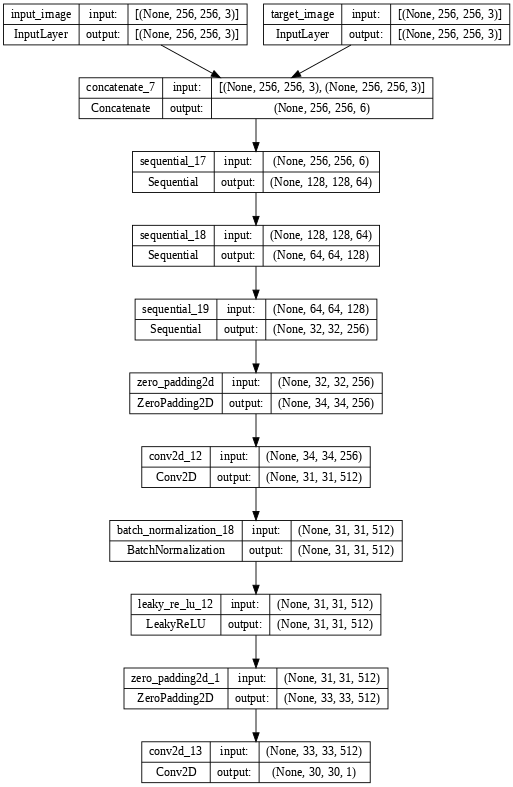

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

测试判别器：

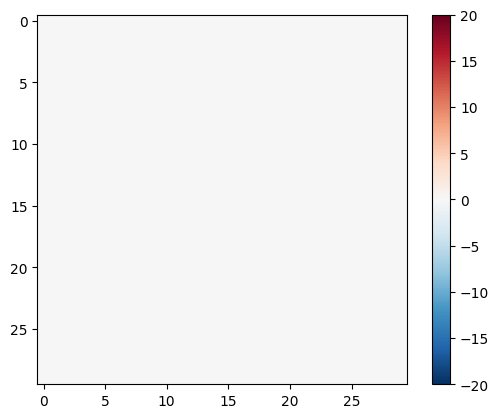

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### 定义判别器损失

- `discriminator_loss` 函数接收 2 个输入：**真实图像**和**生成图像**。
- `real_loss` 是**真实图像**和**一组 1的 sigmoid 的交叉熵损失（因为这些是真实图像）**。
- `generated_loss` 是**生成图像**和**一组 0 的 sigmoid 交叉熵损失（因为这些是伪图像）**。
- `total_loss` 是 `real_loss` 和 `generated_loss` 的总和

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

判别器的训练过程如下所示。

要详细了解架构和超参数，请参阅 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}。

![判别器更新图像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## 定义优化器和检查点 saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 生成图像

编写函数以在训练期间绘制一些图像。

- 将图像从测试集传递到生成器。
- 然后，生成器会将输入图像转换为输出。
- 最后一步是绘制预测，*瞧*！

注：在这里，`training=True` 是有意的，因为在基于测试数据集运行模型时，您需要批次统计信息。如果您使用 training = False，将获得从训练数据集中学习的累积统计信息（您不需要）。

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

测试该函数：

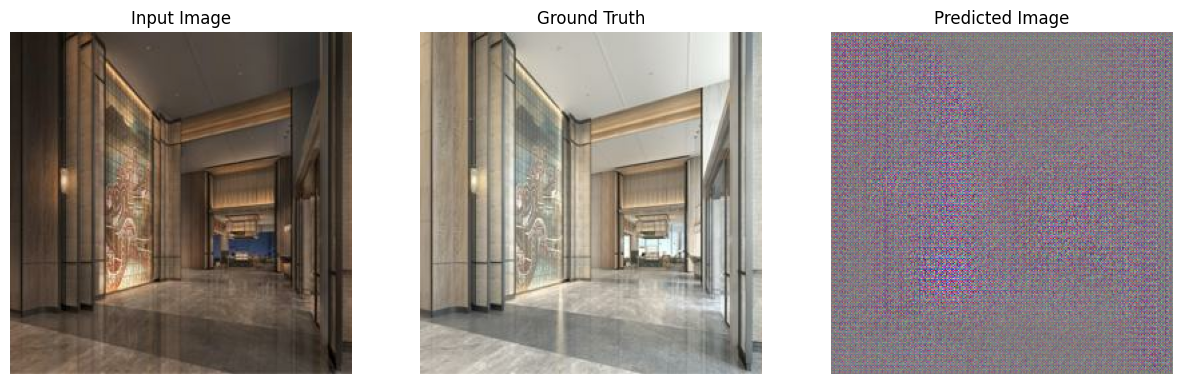

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## 训练

- 为每个样本输入生成一个输出。
- 判别器接收 input_image 和生成的图像作为第一个输入。第二个输入为 input_image 和 target_image。
- 接下来，计算生成器和判别器损失。
- 随后，计算损失相对于生成器和判别器变量（输入）的梯度，并将其应用于优化器。
- 最后，将损失记录到 TensorBoard。

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

NameError: name 'datetime' is not defined

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

实际的训练循环。由于本教程可以运行多个数据集，并且数据集的大小差异很大，因此将训练循环设置为按步骤而非按周期工作。

- 迭代步骤数。
- 每 10 步打印一个点 (`.`)。
- 每 1 千步：清除显示并运行 `generate_images` 以显示进度。
- 每 5 千步：保存一个检查点。

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

此训练循环会保存日志，您可以在 TensorBoard 中查看这些日志以监控训练进度。

如果您使用的是本地计算机，则需要启动一个单独的 TensorBoard 进程。在笔记本中工作时，请在开始训练之前启动查看器以使用 TensorBoard 进行监控。

在笔记本中打开嵌入式 TensorBoard 查看器（抱歉，这不会在 tensorflow.org 上显示）：

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

您可以在 [TensorBoard.dev](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/)。

最后，运行训练循环：

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

与简单的分类或回归模型相比，在训练 GAN（或像 pix2pix 这样的 cGAN）时，对日志的解释更加微妙。要检查的内容包括：

- 检查生成器模型或判别器模型均未“获胜”。如果 `gen_gan_loss` 或 `disc_loss` 变得很低，则表明此模型正在支配另一个模型，并且您未能成功训练组合模型。
- 值 `log(2) = 0.69` 是这些损失的一个良好参考点，因为它表示困惑度为 2：判别器对这两个选项的平均不确定性是相等的。
- 对于 `disc_loss`，低于 `0.69` 的值意味着判别器在真实图像和生成图像的组合集上的表现要优于随机数。
- 对于 `gen_gan_loss`，如果值小于 `0.69`，则表示生成器在欺骗判别器方面的表现要优于随机数。
- 随着训练的进行，`gen_l1_loss` 应当下降。

## 恢复最新的检查点并测试网络

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 使用测试集生成一些图像

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)